# 🧠 Brain Tumor Segmentation Using 3D U-Net and Attention U-Net (PyTorch)
### Advanced Deep Learning Pipeline for MRI Segmentation

This notebook presents a complete deep learning pipeline for 3D brain tumor segmentation from MRI images using U-Net and Attention U-Net architectures.

**Features:**
- Data preprocessing and loading for multi-modal MRI
- Custom PyTorch dataset and data loader
- Implementation of U-Net and Attention U-Net
- Advanced training loop with early stopping and learning rate scheduling
- Quantitative evaluation (Dice, loss curves) and qualitative visualizations
- Easily adaptable for research, internship, and clinical exploration

----


## ⚙️ Setup and Dependencies

In [31]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import nibabel as nib

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('✅ Using device:', DEVICE)
NUM_CLASSES = 4  # background, edema, non-enhancing tumor, enhancing tumor


✅ Using device: cuda


In [2]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ CUDA available:", torch.cuda.is_available())
print("🧠 Device:", DEVICE)


✅ CUDA available: True
🧠 Device: cuda


## 📂 Dataset Loader: Patch-wise, Lazy Loading from `.nii.gz` (BraTS2021)


In [6]:
# BraTS 2023 Patch-based 3D Dataset
# This dataset class loads 3D patches from BraTS patient directories.
import nibabel as nib
import torch
import numpy as np
from torch.utils.data import Dataset
import os, random

class BraTSPatch3DDataset(Dataset):
    def __init__(self, patient_dirs, patch_depth=64, augment=False):
        self.patch_depth = patch_depth
        self.augment = augment
        self.patients = []       # Preloaded patients: (image, seg)
        self.patch_index = []    # List of (patient_idx, z_start)

        for i, p in enumerate(patient_dirs):
            pid = os.path.basename(p)

            def load_modality(name):
                path = os.path.join(p, f"{pid}_{name}.nii.gz")
                return nib.load(path).get_fdata(dtype=np.float32)

            # Load and normalize once
            flair = load_modality("flair")
            t1 = load_modality("t1")
            t1ce = load_modality("t1ce")
            t2 = load_modality("t2")
            seg = load_modality("seg")

            image = np.stack([flair, t1, t1ce, t2], axis=0)  # Shape: (4, H, W, D)
            for c in range(4):
                img = image[c]
                image[c] = (img - np.mean(img)) / (np.std(img) + 1e-5)

            self.patients.append((image, seg))

            # Create patch indices
            depth = image.shape[-1]
            for z in range(0, depth - patch_depth, patch_depth // 2):
                self.patch_index.append((i, z))

    def __len__(self):
        return len(self.patch_index)

    def __getitem__(self, idx):
        patient_idx, z = self.patch_index[idx]
        image, seg = self.patients[patient_idx]

        patch_img = image[:, :, :, z:z+self.patch_depth]
        patch_seg = seg[:, :, z:z+self.patch_depth]

        patch_img = torch.tensor(patch_img.copy(), dtype=torch.float32)
        patch_seg = torch.tensor(patch_seg.copy(), dtype=torch.long)

        if self.augment and random.random() > 0.5:
            patch_img = torch.flip(patch_img, dims=[3])
            patch_seg = torch.flip(patch_seg, dims=[2])

        return patch_img, patch_seg


## 🔀 Dataset Split: Train & Validation
We use an 80/20 split to train and evaluate performance.

In [7]:
# Set your BraTS2021 root directory
root_dir = r"C:\Users\amira\Downloads\BraTS2021_Training_Data"

# Gather patient directories
patient_dirs = sorted([
    os.path.join(root_dir, d)
    for d in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, d))
])
random.shuffle(patient_dirs)  # Shuffle for randomness

# Patient-level 80/20 split to avoid data leakage
split_idx = int(0.8 * len(patient_dirs))
train_patients = patient_dirs[:split_idx]
val_patients = patient_dirs[split_idx:]

# Initialize datasets

class BraTSPatch3DDataset(Dataset):
    def __init__(self, patient_dirs, patch_depth=64, augment=False):
        self.patient_dirs = patient_dirs
        self.patch_depth = patch_depth
        self.augment = augment
        self.patch_index = []  # Stores (patient_index, z_start)

        # Build patch index only for tumor-containing patches
        for i, p in enumerate(patient_dirs):
            seg_path = os.path.join(p, os.path.basename(p) + '_seg.nii.gz')
            seg = nib.load(seg_path).get_fdata()
            depth = seg.shape[-1]

            for z in range(0, depth - patch_depth, patch_depth // 2):
                patch = seg[:, :, z:z+patch_depth]
                if np.max(patch) > 0:  # ✅ Skip background-only patches
                    self.patch_index.append((i, z))

    def __len__(self):
        return len(self.patch_index)

    def __getitem__(self, idx):
        patient_idx, z = self.patch_index[idx]
        p = self.patient_dirs[patient_idx]
        pid = os.path.basename(p)

        def load_modality(name):
            path = os.path.join(p, f"{pid}_{name}.nii.gz")
            return nib.load(path).get_fdata(dtype=np.float32)

        # Load 4 MRI modalities
        flair = load_modality("flair")
        t1 = load_modality("t1")
        t1ce = load_modality("t1ce")
        t2 = load_modality("t2")
        seg = load_modality("seg")

        # Extract 3D patch: (C, H, W, D)
        image = np.stack([flair, t1, t1ce, t2], axis=0)[:, :, :, z:z+self.patch_depth]
        mask = seg[:, :, z:z+self.patch_depth]

        # Normalize each channel independently
        for i in range(4):
            img = image[i]
            image[i] = (img - np.mean(img)) / (np.std(img) + 1e-5)

        # Convert to tensors
        image = torch.tensor(image.copy(), dtype=torch.float32)
        mask = torch.tensor(mask.copy(), dtype=torch.long)

        # Optional horizontal flip
        if self.augment and random.random() > 0.5:
            image = torch.flip(image, dims=[3])  # flip in depth
            mask = torch.flip(mask, dims=[2])

        return image, mask

train_dataset = BraTSPatch3DDataset(train_patients, patch_depth=32, augment=True)
val_dataset = BraTSPatch3DDataset(val_patients, patch_depth=32, augment=False)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# Display info
print("✅ Dataset loaded successfully")
print("Train patients:", len(train_patients))
print("Val patients:", len(val_patients))
print("Train samples (patches):", len(train_dataset))
print("Val samples (patches):", len(val_dataset))


✅ Dataset loaded successfully
Train patients: 1000
Val patients: 251
Train samples (patches): 5741
Val samples (patches): 1425


## 🧠 U-Net 3D and Attention U-Net3D Architectures

In [5]:
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, 1), nn.BatchNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, 1), nn.BatchNorm3d(F_int))
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.BatchNorm3d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        return x * self.psi(self.relu(self.W_g(g) + self.W_x(x)))

class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.att2 = AttentionBlock3D(64, 64, 32)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.att1 = AttentionBlock3D(32, 32, 16)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.att2(self.up2(b), e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.att1(self.up1(d2), e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.out_conv(d1)


## 🧪 Training loop Function (AMP + EarlyStopping + Dice Score)

In [10]:

from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

def dice_coeff(pred, target, eps=1e-6):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred == target).float().sum()
    return (2. * intersection) / (pred.numel() + target.numel() + eps)

def train_model(model, train_loader, val_loader, name, epochs=100):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = GradScaler()
    best_dice = 0
    patience = 10
    trigger = 0
    val_dices = []

    print(f"\n⏳ Measuring first batch load time...")
    t0 = time.time()
    _ = next(iter(train_loader))
    print(f"✅ First batch loaded in {time.time() - t0:.2f} seconds.\n")

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        print(f"\n🔁 Epoch {epoch}/{epochs}")
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()

            with autocast():
                out = model(x)
                # Ensure labels are within valid range
                y = torch.clamp(y, 0, out.shape[1] - 1)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

            # Batch progress logging
            if i % 100 == 0:
                print(f"   ↪ Batch {i}/{len(train_loader)} | Loss: {loss.item():.4f}")

        # Validation
        model.eval()
        dice = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                with autocast():
                    pred = torch.argmax(model(x), dim=1)
                dice += dice_coeff(pred.cpu(), y.cpu())

        avg_dice = dice / len(val_loader)
        val_dices.append(avg_dice.item())
        print(f"✅ Epoch {epoch} complete | Loss: {total_loss:.4f} | Val Dice: {avg_dice:.4f}")
        scheduler.step(total_loss)

        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), f"{name}_best.pth")
            print(f"💾 Best model saved with Dice: {best_dice:.4f}")
            trigger = 0
        else:
            trigger += 1
            print(f"⚠️ No improvement. Patience: {trigger}/{patience}")
            if trigger >= patience:
                print("⏹️ Early stopping triggered.")
                break

    # Plot Dice over epochs
    plt.figure(figsize=(8, 4))
    plt.plot(val_dices, label="Validation Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.title(f"Dice Curve for {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
labels = []
for _, y in train_loader:
    labels.append(y.max().item())
    break

print("Max label value in dataset:", max(labels))


Max label value in dataset: 4



⏳ Measuring first batch load time...
✅ First batch loaded in 0.34 seconds.


🔁 Epoch 1/100
   ↪ Batch 0/5741 | Loss: 1.2150
   ↪ Batch 100/5741 | Loss: 0.7321
   ↪ Batch 200/5741 | Loss: 0.6350
   ↪ Batch 300/5741 | Loss: 0.4842
   ↪ Batch 400/5741 | Loss: 0.3879
   ↪ Batch 500/5741 | Loss: 0.3242
   ↪ Batch 600/5741 | Loss: 0.2751
   ↪ Batch 700/5741 | Loss: 0.2488
   ↪ Batch 800/5741 | Loss: 0.1906
   ↪ Batch 900/5741 | Loss: 0.1670
   ↪ Batch 1000/5741 | Loss: 0.1460
   ↪ Batch 1100/5741 | Loss: 0.1246
   ↪ Batch 1200/5741 | Loss: 0.1154
   ↪ Batch 1300/5741 | Loss: 0.1065
   ↪ Batch 1400/5741 | Loss: 0.0789
   ↪ Batch 1500/5741 | Loss: 0.1102
   ↪ Batch 1600/5741 | Loss: 0.0640
   ↪ Batch 1700/5741 | Loss: 0.0641
   ↪ Batch 1800/5741 | Loss: 0.0525
   ↪ Batch 1900/5741 | Loss: 0.0449
   ↪ Batch 2000/5741 | Loss: 0.0430
   ↪ Batch 2100/5741 | Loss: 0.0661
   ↪ Batch 2200/5741 | Loss: 0.0327
   ↪ Batch 2300/5741 | Loss: 0.0291
   ↪ Batch 2400/5741 | Loss: 0.0298
   ↪ Batch 2500/5741

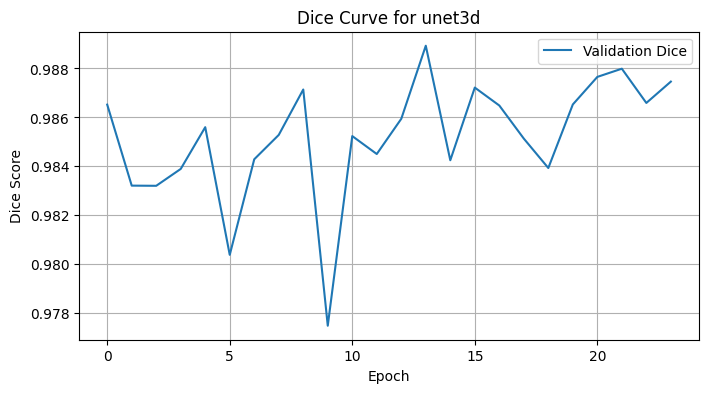

In [8]:
unet = UNet3D()
train_model(unet, train_loader, val_loader, name="unet3d")


In [8]:
import torch
import numpy as np
from medpy.metric.binary import hd95
from monai.metrics import DiceMetric

def evaluate_model(model, val_loader, num_classes=4):
    model.eval()
    dices = []
    hd95s = [[] for _ in range(num_classes)]
    dice_metric = DiceMetric(include_background=True, reduction="none")

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = model(x)
            preds = torch.argmax(preds, dim=1)

            # MONAI Dice expects shape (B, C, ...)
            y_onehot = torch.nn.functional.one_hot(y, num_classes=num_classes).permute(0, 4, 1, 2, 3)
            p_onehot = torch.nn.functional.one_hot(preds, num_classes=num_classes).permute(0, 4, 1, 2, 3)

            dice = dice_metric(p_onehot.float(), y_onehot.float())
            dices.append(dice.cpu().numpy())

            y_np = y.cpu().numpy()
            pred_np = preds.cpu().numpy()

            # Hausdorff (per class, per sample)
            for b in range(pred_np.shape[0]):
                for cls in range(num_classes):
                    gt_bin = (y_np[b] == cls).astype(np.uint8)
                    pred_bin = (pred_np[b] == cls).astype(np.uint8)
                    if np.any(gt_bin) and np.any(pred_bin):
                        hd = hd95(pred_bin, gt_bin)
                        hd95s[cls].append(hd)

    # Final Scores
    dices = np.vstack(dices)
    mean_dice_per_class = np.nanmean(dices, axis=0)

    mean_hd95_per_class = [np.mean(hd) if len(hd) > 0 else np.nan for hd in hd95s]

    print("\n📊 **Per-Class Dice Scores:**")
    for i, d in enumerate(mean_dice_per_class):
        print(f"  Class {i}: Dice = {d:.4f}")

    print("\n📐 **Per-Class Hausdorff 95 Distances (lower is better):**")
    for i, h in enumerate(mean_hd95_per_class):
        print(f"  Class {i}: HD95 = {h:.2f} voxels")

    return mean_dice_per_class, mean_hd95_per_class


In [9]:
for x, y in val_loader:
    print("Label shape:", y.shape)
    print("Label unique values:", torch.unique(y))
    break


Label shape: torch.Size([1, 240, 240, 32])
Label unique values: tensor([0, 1, 2, 4])



⏳ Measuring first batch load time...
✅ First batch loaded in 0.31 seconds.


🔁 Epoch 1/100
   ↪ Batch 0/5741 | Loss: 1.0701
   ↪ Batch 100/5741 | Loss: 0.5815
   ↪ Batch 200/5741 | Loss: 0.4653
   ↪ Batch 300/5741 | Loss: 0.3809
   ↪ Batch 400/5741 | Loss: 0.3556
   ↪ Batch 500/5741 | Loss: 0.3160
   ↪ Batch 600/5741 | Loss: 0.2126
   ↪ Batch 700/5741 | Loss: 0.1837
   ↪ Batch 800/5741 | Loss: 0.1390
   ↪ Batch 900/5741 | Loss: 0.1282
   ↪ Batch 1000/5741 | Loss: 0.1277
   ↪ Batch 1100/5741 | Loss: 0.1010
   ↪ Batch 1200/5741 | Loss: 0.0795
   ↪ Batch 1300/5741 | Loss: 0.0896
   ↪ Batch 1400/5741 | Loss: 0.0651
   ↪ Batch 1500/5741 | Loss: 0.0561
   ↪ Batch 1600/5741 | Loss: 0.0486
   ↪ Batch 1700/5741 | Loss: 0.0408
   ↪ Batch 1800/5741 | Loss: 0.0377
   ↪ Batch 1900/5741 | Loss: 0.1360
   ↪ Batch 2000/5741 | Loss: 0.0358
   ↪ Batch 2100/5741 | Loss: 0.0323
   ↪ Batch 2200/5741 | Loss: 0.0272
   ↪ Batch 2300/5741 | Loss: 0.0843
   ↪ Batch 2400/5741 | Loss: 0.0488
   ↪ Batch 2500/5741

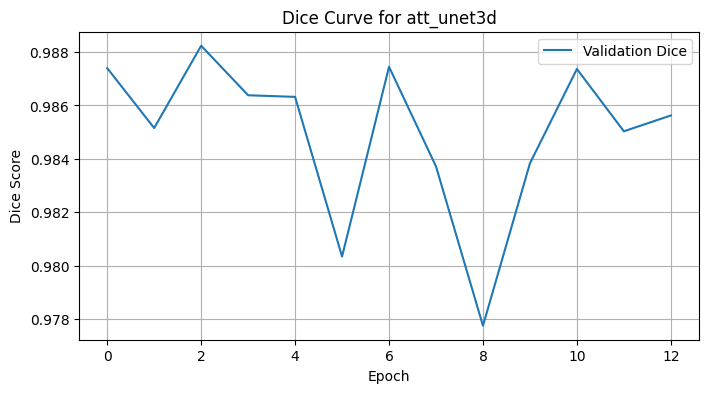

In [12]:
att_unet = AttentionUNet3D()
train_model(att_unet, train_loader, val_loader, name="att_unet3d")

## 📊 Ensemble Prediction and Visualization
 This combines predictions from U-Net and Attention U-Net, averages the logits, and visualizes the ensemble result.

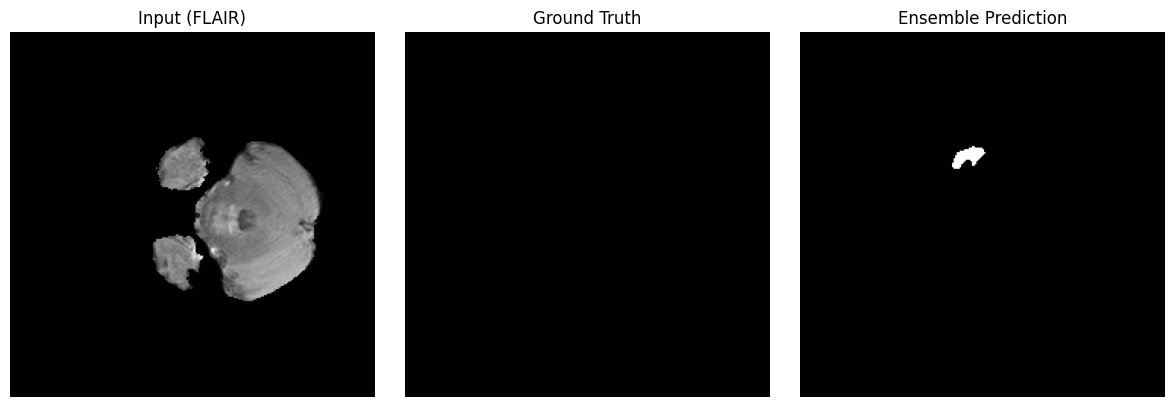

In [ ]:
import matplotlib.pyplot as plt

def ensemble_predict(x):
    model1 = UNet3D().to(DEVICE)
    model2 = AttentionUNet3D().to(DEVICE)
    model1.load_state_dict(torch.load("unet3d_best1.pth"))
    model2.load_state_dict(torch.load("att_unet3d_best1.pth"))
    model1.eval(); model2.eval()

    with torch.no_grad():
        out1 = model1(x)
        out2 = model2(x)
        avg_out = (out1 + out2) / 2
        pred = torch.argmax(avg_out, dim=1)
    return pred

def visualize_ensemble(val_loader):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = ensemble_predict(x)

    mid_slice = x.shape[-1] // 2
    for i in range(min(2, x.shape[0])):  # show 2 examples max
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(x[i][0, :, :, mid_slice].cpu(), cmap='gray')
        plt.title("Input (FLAIR)")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(y[i, :, :, mid_slice].cpu(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred[i, :, :, mid_slice].cpu(), cmap='gray')
        plt.title("Ensemble Prediction")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
visualize_ensemble(val_loader)

# 🔎 Inference and Visualization on a Single Patient

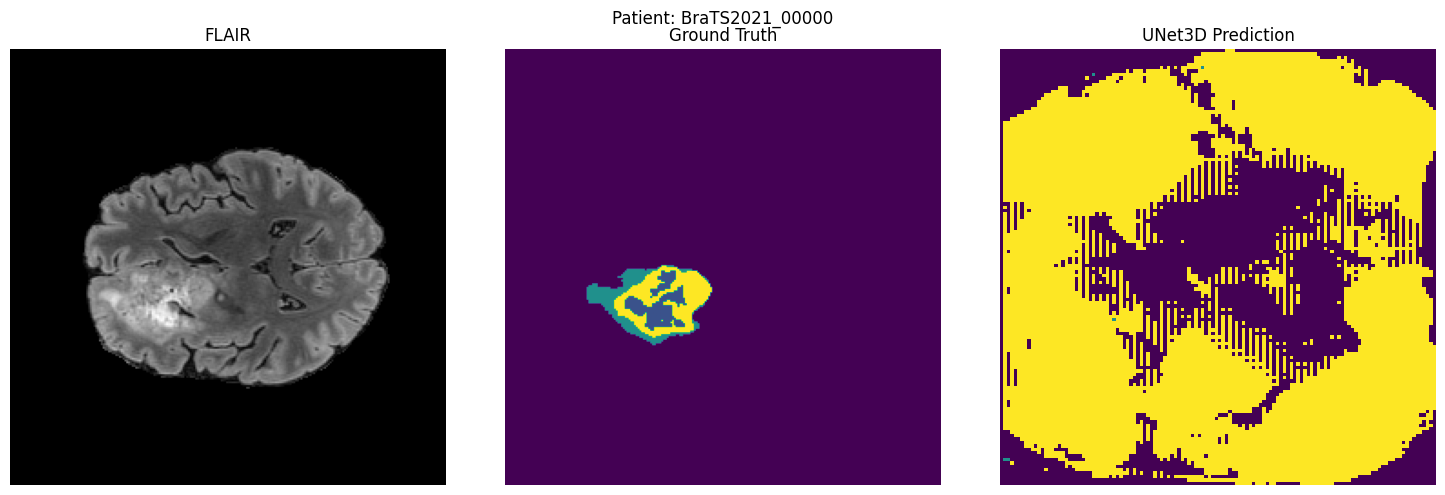

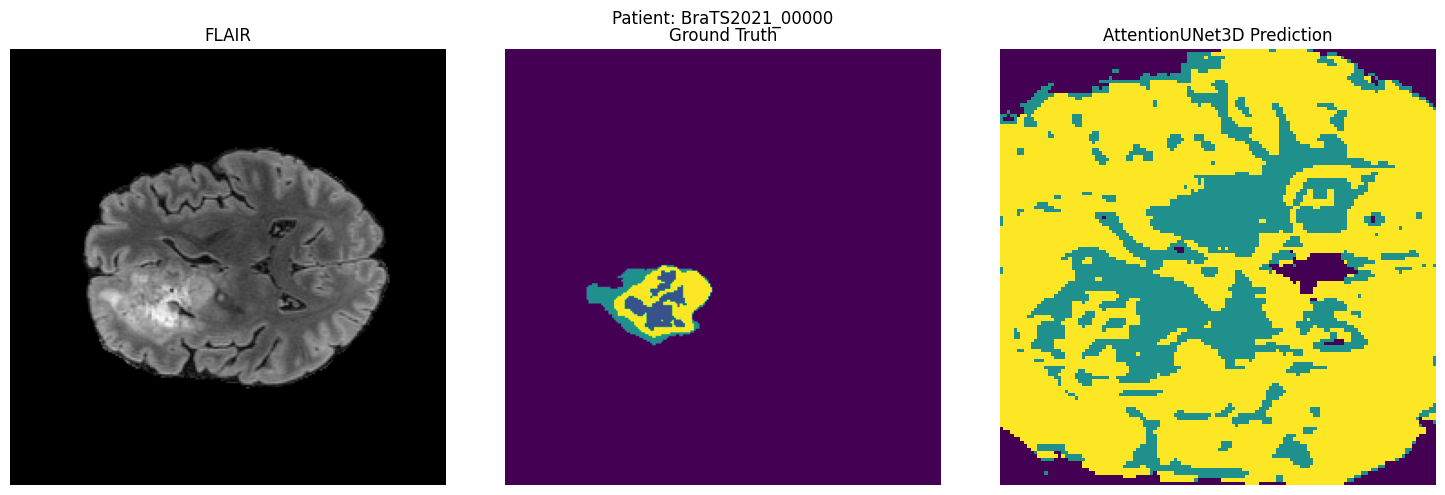

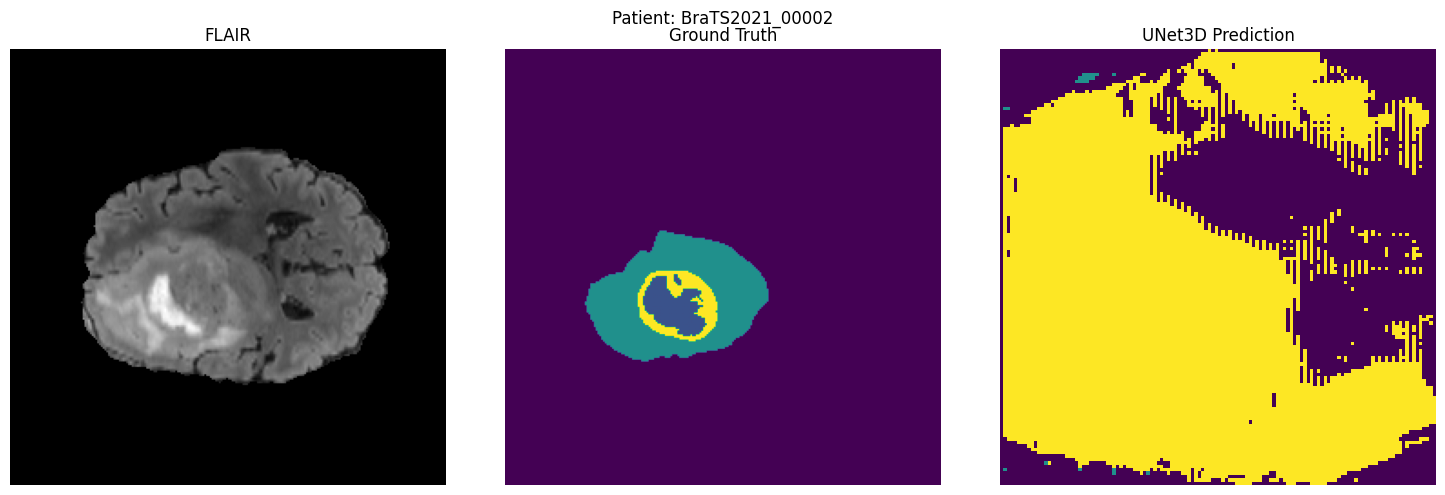

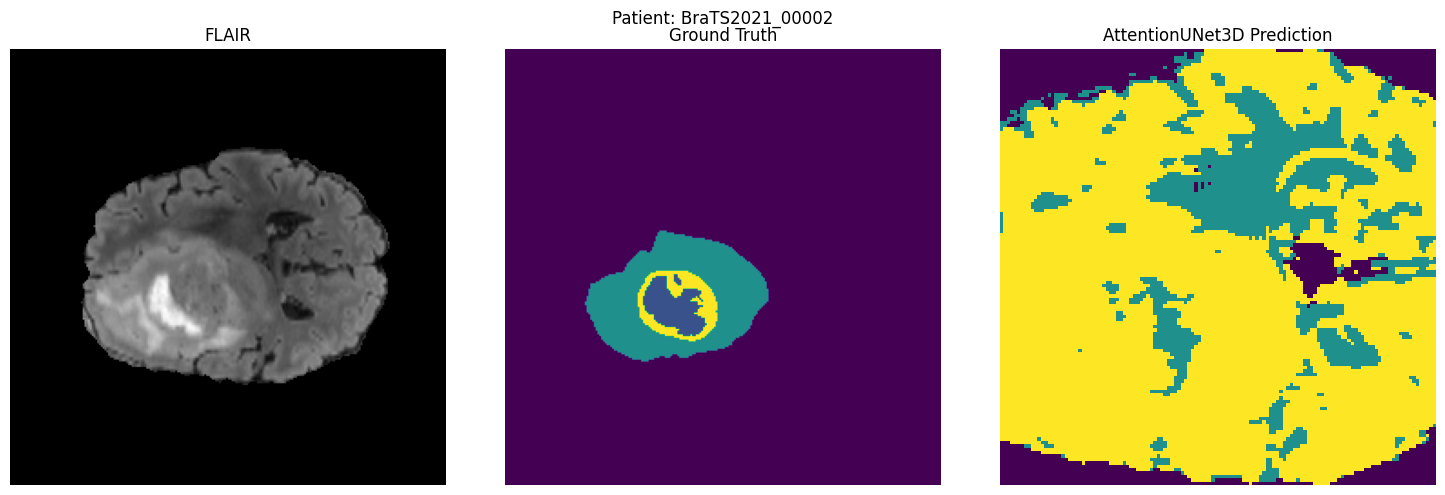

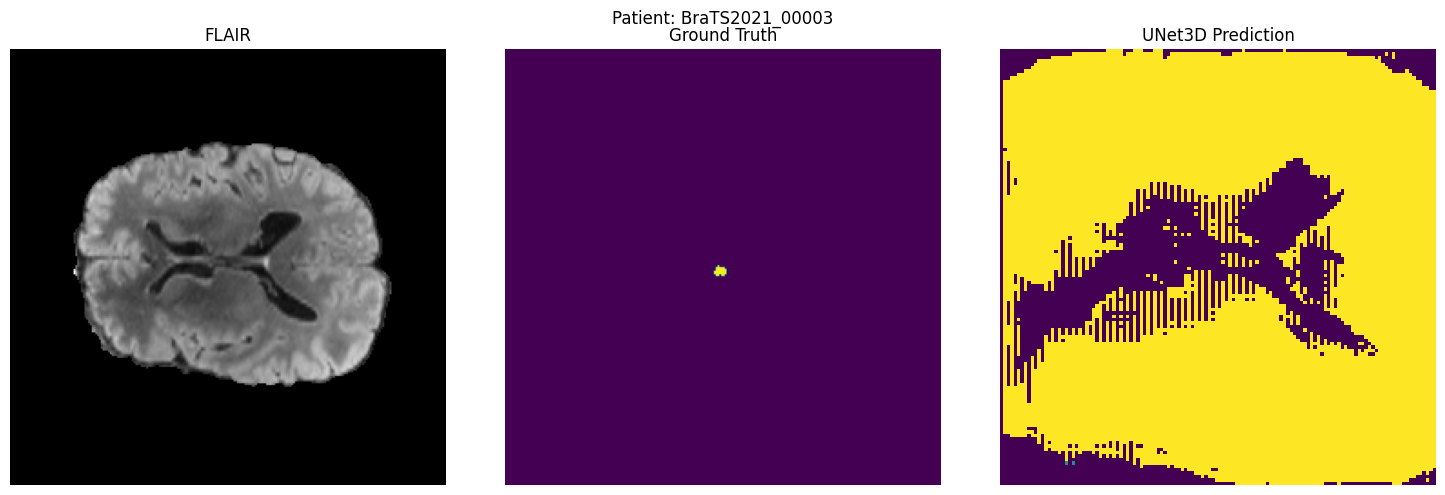

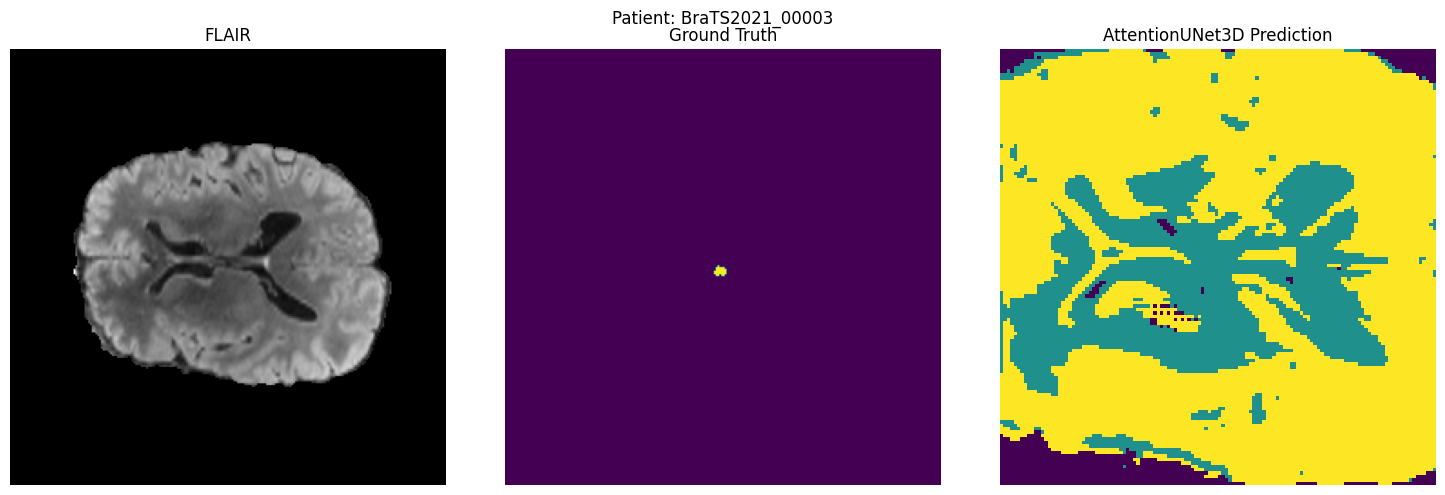

In [ ]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import numpy as np

def center_crop_or_pad(img, target_shape):
    """
    Center crop or pad a 3D numpy array to the target shape.
    img: shape (..., H, W, D)
    target_shape: tuple (H, W, D)
    """
    out = np.zeros((img.shape[0],) + target_shape, dtype=img.dtype)
    for c in range(img.shape[0]):
        for i in range(3):
            diff = img.shape[i+1] - target_shape[i]
            if diff < 0:
                pad_before = -diff // 2
                pad_after = -diff - pad_before
                slc = [slice(None)] * 4
                slc[i+1] = slice(None)
                out[c] = np.pad(img[c], [(0,0) if j != i else (pad_before, pad_after) for j in range(3)], mode='constant')
            else:
                crop_before = diff // 2
                crop_after = crop_before + target_shape[i]
                slc = [slice(None)] * 4
                slc[i+1] = slice(crop_before, crop_after)
                img = img
        out[c] = img[c, 
                      (img.shape[1] - target_shape[0]) // 2 : (img.shape[1] - target_shape[0]) // 2 + target_shape[0],
                      (img.shape[2] - target_shape[1]) // 2 : (img.shape[2] - target_shape[1]) // 2 + target_shape[1],
                      (img.shape[3] - target_shape[2]) // 2 : (img.shape[3] - target_shape[2]) // 2 + target_shape[2]
                     ]
    return out

def run_inference_on_patient(patient_dir, model_path, model_class, input_shape=(4, 128, 128, 64)):
    flair = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_flair.nii.gz")).get_fdata()
    t1 = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_t1.nii.gz")).get_fdata()
    t1ce = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_t1ce.nii.gz")).get_fdata()
    t2 = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_t2.nii.gz")).get_fdata()
    
    image = np.stack([flair, t1, t1ce, t2], axis=0).astype(np.float32)
    image = center_crop_or_pad(image, input_shape[1:])
    image = torch.tensor(image).unsqueeze(0).to(DEVICE)
    
    model = model_class().to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    return prediction

def visualize_and_save(patient_dir, prediction, model_name):
    flair_path = os.path.join(patient_dir, os.path.basename(patient_dir) + "_flair.nii.gz")
    gt_path = os.path.join(patient_dir, os.path.basename(patient_dir) + "_seg.nii.gz")
    
    flair = nib.load(flair_path).get_fdata()
    gt = nib.load(gt_path).get_fdata()
    
    # Use the prediction's depth for mid_slice
    mid_slice = prediction.shape[-1] // 2

    # Safely get the same slice from flair and gt (centered)
    def get_center_slice(arr):
        d = arr.shape[-1]
        start = max(0, (d - prediction.shape[-1]) // 2)
        end = start + prediction.shape[-1]
        arr_cropped = arr[..., start:end]
        return arr_cropped

    flair_c = get_center_slice(flair)
    gt_c = get_center_slice(gt)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(flair_c[:, :, mid_slice], cmap='gray')
    axs[0].set_title("FLAIR")
    axs[0].axis("off")

    axs[1].imshow(gt_c[:, :, mid_slice])
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(prediction[:, :, mid_slice])
    axs[2].set_title(f"{model_name} Prediction")
    axs[2].axis("off")
    
    plt.suptitle(f"Patient: {os.path.basename(patient_dir)}")
    plt.tight_layout()
    plt.savefig(f"pred_{model_name}_{os.path.basename(patient_dir)}.png")
    plt.show()

# 🔄 Loop over multiple patients
data_root = "C:\\Users\\amira\\Downloads\\BraTS2021_Training_Data"
patient_dirs = sorted([os.path.join(data_root, d) for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))])

# Only test on 3 for now
for patient_dir in patient_dirs[:3]:
    pred = run_inference_on_patient(patient_dir, "unet3d_best1.pth", UNet3D)
    visualize_and_save(patient_dir, pred, "UNet3D")

    pred_att = run_inference_on_patient(patient_dir, "att_unet3d_best1.pth", AttentionUNet3D)
    visualize_and_save(patient_dir, pred_att, "AttentionUNet3D")


## Export to TorchScript & ONNX
This cell lets you export both U-Net and Attention U-Net models for deployment (in PyTorch or external tools like TensorRT or ONNX Runtime).

✅ unet3d.pt and att_unet3d.pt → usable in PyTorch mobile or C++ inference

✅ unet3d.onnx and att_unet3d.onnx → compatible with ONNX Runtime, TensorRT, OpenVINO, etc.

In [24]:
import torch.onnx

def export_model(model_class, weight_path, name="unet3d", input_shape=(1, 4, 128, 128, 64)):
    model = model_class().to(DEVICE)
    model.load_state_dict(torch.load(weight_path))
    model.eval()

    dummy_input = torch.randn(input_shape).to(DEVICE)

    # ✅ Export to TorchScript
    traced = torch.jit.trace(model, dummy_input)
    traced.save(f"{name}.pt")
    print(f"✅ TorchScript saved: {name}.pt")

    # ✅ Export to ONNX
    torch.onnx.export(
        model,
        dummy_input,
        f"{name}.onnx",
        export_params=True,
        opset_version=14,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}},
        do_constant_folding=True
    )
    print(f"✅ ONNX saved: {name}.onnx")

# Export both models
export_model(UNet3D, "unet3d_best.pth", name="unet3d")
export_model(AttentionUNet3D, "att_unet3d_best.pth", name="att_unet3d")


✅ TorchScript saved: unet3d.pt
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

✅ ONNX saved: unet3d.onnx
✅ TorchScript saved: att_unet3d.pt
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

✅ ONNX saved: att_unet3d.onnx


#  Dice Score & Loss Tracking Plot
We’ll modify the training function slightly to return per-epoch loss and Dice values, and then plot them separately.

In [8]:
def train_model(model, train_loader, val_loader, name, epochs=100):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = GradScaler()
    best_dice = 0
    patience = 10
    trigger = 0

    history = {
        "train_loss": [],
        "val_dice": []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for x, y in tqdm(train_loader, desc=f"[{name}] Epoch {epoch}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            with autocast():
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        model.eval()
        dice = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                with autocast():
                    pred = torch.argmax(model(x), dim=1)
                dice += dice_coeff(pred.cpu(), y.cpu())

        avg_dice = dice / len(val_loader)
        history["train_loss"].append(total_loss)
        history["val_dice"].append(avg_dice.item())

        print(f"Epoch {epoch} | Loss: {total_loss:.4f} | Val Dice: {avg_dice:.4f}")
        scheduler.step(total_loss)

        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), f"{name}_best.pth")
            print(f"✅ Saved best model with Dice: {best_dice:.4f}")
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("⏹️ Early stopping triggered.")
                break

    return history

def plot_history(history, title="Training History"):
    epochs = list(range(1, len(history["train_loss"]) + 1))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_dice"], label="Val Dice", marker="x")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.grid(True)
    plt.legend()
    plt.show()



In [9]:
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=5):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, 1), nn.BatchNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, 1), nn.BatchNorm3d(F_int))
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.BatchNorm3d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        return x * self.psi(self.relu(self.W_g(g) + self.W_x(x)))

class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=5):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.att2 = AttentionBlock3D(64, 64, 32)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.att1 = AttentionBlock3D(32, 32, 16)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.att2(self.up2(b), e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.att1(self.up1(d2), e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.out_conv(d1)


[unet3d] Epoch 1: 100%|██████████| 5741/5741 [46:43<00:00,  2.05it/s] 


Epoch 1 | Loss: 901.5938 | Val Dice: 0.9884
✅ Saved best model with Dice: 0.9884


[unet3d] Epoch 2: 100%|██████████| 5741/5741 [55:03<00:00,  1.74it/s] 


Epoch 2 | Loss: 103.3043 | Val Dice: 0.9844


[unet3d] Epoch 3: 100%|██████████| 5741/5741 [55:00<00:00,  1.74it/s] 


Epoch 3 | Loss: 86.1096 | Val Dice: 0.9836


[unet3d] Epoch 4: 100%|██████████| 5741/5741 [54:21<00:00,  1.76it/s] 


Epoch 4 | Loss: 78.1921 | Val Dice: 0.9569


[unet3d] Epoch 5: 100%|██████████| 5741/5741 [54:31<00:00,  1.75it/s] 


Epoch 5 | Loss: 72.9464 | Val Dice: 0.9866


[unet3d] Epoch 6: 100%|██████████| 5741/5741 [36:36<00:00,  2.61it/s]


Epoch 6 | Loss: 69.6117 | Val Dice: 0.9853


[unet3d] Epoch 7: 100%|██████████| 5741/5741 [36:38<00:00,  2.61it/s]


Epoch 7 | Loss: 67.0256 | Val Dice: 0.9883


[unet3d] Epoch 8: 100%|██████████| 5741/5741 [36:38<00:00,  2.61it/s]


Epoch 8 | Loss: 64.4821 | Val Dice: 0.9824


[unet3d] Epoch 9: 100%|██████████| 5741/5741 [38:03<00:00,  2.51it/s]


Epoch 9 | Loss: 62.0319 | Val Dice: 0.9904
✅ Saved best model with Dice: 0.9904


[unet3d] Epoch 10: 100%|██████████| 5741/5741 [43:54<00:00,  2.18it/s]


Epoch 10 | Loss: 61.0924 | Val Dice: 0.9902


[unet3d] Epoch 11: 100%|██████████| 5741/5741 [54:48<00:00,  1.75it/s] 


Epoch 11 | Loss: 59.5782 | Val Dice: 0.9887


[unet3d] Epoch 12: 100%|██████████| 5741/5741 [55:00<00:00,  1.74it/s] 


Epoch 12 | Loss: 58.1966 | Val Dice: 0.9840


[unet3d] Epoch 13: 100%|██████████| 5741/5741 [54:43<00:00,  1.75it/s] 


Epoch 13 | Loss: 57.0742 | Val Dice: 0.9908
✅ Saved best model with Dice: 0.9908


[unet3d] Epoch 14: 100%|██████████| 5741/5741 [55:07<00:00,  1.74it/s] 


Epoch 14 | Loss: 56.0075 | Val Dice: 0.9828


[unet3d] Epoch 15: 100%|██████████| 5741/5741 [55:10<00:00,  1.73it/s] 


Epoch 15 | Loss: 55.1822 | Val Dice: 0.9830


[unet3d] Epoch 16: 100%|██████████| 5741/5741 [54:45<00:00,  1.75it/s] 


Epoch 16 | Loss: 54.1584 | Val Dice: 0.9907


[unet3d] Epoch 17: 100%|██████████| 5741/5741 [54:46<00:00,  1.75it/s] 


Epoch 17 | Loss: 53.1622 | Val Dice: 0.9695


[unet3d] Epoch 18: 100%|██████████| 5741/5741 [55:02<00:00,  1.74it/s] 


Epoch 18 | Loss: 52.5273 | Val Dice: 0.9921
✅ Saved best model with Dice: 0.9921


[unet3d] Epoch 19: 100%|██████████| 5741/5741 [55:07<00:00,  1.74it/s] 


Epoch 19 | Loss: 52.1918 | Val Dice: 0.9902


[unet3d] Epoch 20: 100%|██████████| 5741/5741 [55:08<00:00,  1.74it/s] 


Epoch 20 | Loss: 51.0588 | Val Dice: 0.9907


[unet3d] Epoch 21: 100%|██████████| 5741/5741 [54:46<00:00,  1.75it/s] 


Epoch 21 | Loss: 50.5550 | Val Dice: 0.9895


[unet3d] Epoch 22: 100%|██████████| 5741/5741 [54:49<00:00,  1.75it/s] 


Epoch 22 | Loss: 50.3429 | Val Dice: 0.9876


[unet3d] Epoch 23: 100%|██████████| 5741/5741 [55:11<00:00,  1.73it/s] 


Epoch 23 | Loss: 49.3939 | Val Dice: 0.9872


[unet3d] Epoch 24: 100%|██████████| 5741/5741 [54:56<00:00,  1.74it/s] 


Epoch 24 | Loss: 49.1745 | Val Dice: 0.9837


[unet3d] Epoch 25: 100%|██████████| 5741/5741 [54:46<00:00,  1.75it/s] 


Epoch 25 | Loss: 48.2879 | Val Dice: 0.9570


[unet3d] Epoch 26: 100%|██████████| 5741/5741 [54:47<00:00,  1.75it/s] 


Epoch 26 | Loss: 47.9759 | Val Dice: 0.9807


[unet3d] Epoch 27: 100%|██████████| 5741/5741 [54:49<00:00,  1.75it/s] 


Epoch 27 | Loss: 47.2399 | Val Dice: 0.9769


[unet3d] Epoch 28: 100%|██████████| 5741/5741 [54:31<00:00,  1.76it/s] 


Epoch 28 | Loss: 46.7753 | Val Dice: 0.9823
⏹️ Early stopping triggered.


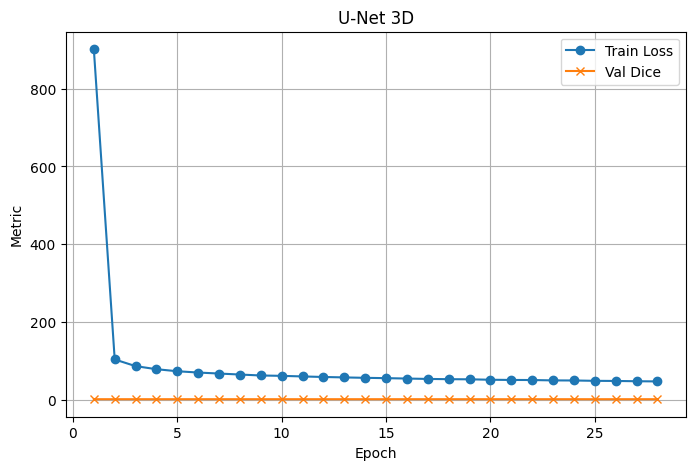

[att_unet3d] Epoch 1: 100%|██████████| 5741/5741 [56:54<00:00,  1.68it/s] 


Epoch 1 | Loss: 788.4317 | Val Dice: 0.9881
✅ Saved best model with Dice: 0.9881


[att_unet3d] Epoch 2: 100%|██████████| 5741/5741 [56:48<00:00,  1.68it/s] 


Epoch 2 | Loss: 105.3039 | Val Dice: 0.9895
✅ Saved best model with Dice: 0.9895


[att_unet3d] Epoch 3: 100%|██████████| 5741/5741 [57:23<00:00,  1.67it/s]  


Epoch 3 | Loss: 85.9339 | Val Dice: 0.9871


[att_unet3d] Epoch 4: 100%|██████████| 5741/5741 [56:54<00:00,  1.68it/s] 


Epoch 4 | Loss: 78.1049 | Val Dice: 0.9886


[att_unet3d] Epoch 5: 100%|██████████| 5741/5741 [56:57<00:00,  1.68it/s] 


Epoch 5 | Loss: 74.0054 | Val Dice: 0.9904
✅ Saved best model with Dice: 0.9904


[att_unet3d] Epoch 6: 100%|██████████| 5741/5741 [57:03<00:00,  1.68it/s] 


Epoch 6 | Loss: 69.6408 | Val Dice: 0.9870


[att_unet3d] Epoch 7: 100%|██████████| 5741/5741 [57:11<00:00,  1.67it/s] 


Epoch 7 | Loss: 66.3541 | Val Dice: 0.9881


[att_unet3d] Epoch 8: 100%|██████████| 5741/5741 [56:47<00:00,  1.68it/s]  


Epoch 8 | Loss: 64.5335 | Val Dice: 0.9905
✅ Saved best model with Dice: 0.9905


[att_unet3d] Epoch 9: 100%|██████████| 5741/5741 [1:00:33<00:00,  1.58it/s]


Epoch 9 | Loss: 62.7546 | Val Dice: 0.9891


[att_unet3d] Epoch 10: 100%|██████████| 5741/5741 [56:43<00:00,  1.69it/s] 


Epoch 10 | Loss: 61.1003 | Val Dice: 0.9857


[att_unet3d] Epoch 11: 100%|██████████| 5741/5741 [57:18<00:00,  1.67it/s] 


Epoch 11 | Loss: 59.9625 | Val Dice: 0.9877


[att_unet3d] Epoch 12: 100%|██████████| 5741/5741 [41:41<00:00,  2.30it/s]


Epoch 12 | Loss: 58.6428 | Val Dice: 0.9856


[att_unet3d] Epoch 13: 100%|██████████| 5741/5741 [41:57<00:00,  2.28it/s]


Epoch 13 | Loss: 57.8585 | Val Dice: 0.9856


[att_unet3d] Epoch 14: 100%|██████████| 5741/5741 [40:13<00:00,  2.38it/s]


Epoch 14 | Loss: 56.7254 | Val Dice: 0.9900


[att_unet3d] Epoch 15: 100%|██████████| 5741/5741 [39:56<00:00,  2.40it/s]


Epoch 15 | Loss: 55.2939 | Val Dice: 0.9902


[att_unet3d] Epoch 16: 100%|██████████| 5741/5741 [39:37<00:00,  2.41it/s]


Epoch 16 | Loss: 55.2594 | Val Dice: 0.9902


[att_unet3d] Epoch 17: 100%|██████████| 5741/5741 [47:54<00:00,  2.00it/s]


Epoch 17 | Loss: 53.7042 | Val Dice: 0.9886


[att_unet3d] Epoch 18: 100%|██████████| 5741/5741 [39:40<00:00,  2.41it/s]


Epoch 18 | Loss: 53.4488 | Val Dice: 0.9906
✅ Saved best model with Dice: 0.9906


[att_unet3d] Epoch 19: 100%|██████████| 5741/5741 [39:32<00:00,  2.42it/s]


Epoch 19 | Loss: 52.2015 | Val Dice: 0.9903


[att_unet3d] Epoch 20: 100%|██████████| 5741/5741 [39:29<00:00,  2.42it/s]


Epoch 20 | Loss: 51.6541 | Val Dice: 0.9881


[att_unet3d] Epoch 21: 100%|██████████| 5741/5741 [39:31<00:00,  2.42it/s]


Epoch 21 | Loss: 51.2158 | Val Dice: 0.9875


[att_unet3d] Epoch 22: 100%|██████████| 5741/5741 [39:31<00:00,  2.42it/s]


Epoch 22 | Loss: 50.4339 | Val Dice: 0.9907
✅ Saved best model with Dice: 0.9907


[att_unet3d] Epoch 23: 100%|██████████| 5741/5741 [39:29<00:00,  2.42it/s]


Epoch 23 | Loss: 49.6126 | Val Dice: 0.9887


[att_unet3d] Epoch 24: 100%|██████████| 5741/5741 [38:38<00:00,  2.48it/s]


Epoch 24 | Loss: 49.2931 | Val Dice: 0.9903


[att_unet3d] Epoch 25: 100%|██████████| 5741/5741 [39:34<00:00,  2.42it/s]


Epoch 25 | Loss: 48.6655 | Val Dice: 0.9860


[att_unet3d] Epoch 26: 100%|██████████| 5741/5741 [38:34<00:00,  2.48it/s]


Epoch 26 | Loss: 48.1886 | Val Dice: 0.9878


[att_unet3d] Epoch 27: 100%|██████████| 5741/5741 [38:25<00:00,  2.49it/s]


Epoch 27 | Loss: 47.8196 | Val Dice: 0.9911
✅ Saved best model with Dice: 0.9911


[att_unet3d] Epoch 28: 100%|██████████| 5741/5741 [38:24<00:00,  2.49it/s]


Epoch 28 | Loss: 47.2388 | Val Dice: 0.9893


[att_unet3d] Epoch 29: 100%|██████████| 5741/5741 [38:24<00:00,  2.49it/s]


Epoch 29 | Loss: 46.9115 | Val Dice: 0.9913
✅ Saved best model with Dice: 0.9913


[att_unet3d] Epoch 30: 100%|██████████| 5741/5741 [38:40<00:00,  2.47it/s]


Epoch 30 | Loss: 46.1559 | Val Dice: 0.9903


[att_unet3d] Epoch 31: 100%|██████████| 5741/5741 [38:26<00:00,  2.49it/s]


Epoch 31 | Loss: 45.6564 | Val Dice: 0.9863


[att_unet3d] Epoch 32: 100%|██████████| 5741/5741 [38:25<00:00,  2.49it/s]


Epoch 32 | Loss: 45.2456 | Val Dice: 0.9901


[att_unet3d] Epoch 33: 100%|██████████| 5741/5741 [47:37<00:00,  2.01it/s]


Epoch 33 | Loss: 44.7842 | Val Dice: 0.9877


[att_unet3d] Epoch 34: 100%|██████████| 5741/5741 [50:22<00:00,  1.90it/s] 


Epoch 34 | Loss: 44.7333 | Val Dice: 0.9900


[att_unet3d] Epoch 35: 100%|██████████| 5741/5741 [2:03:00<00:00,  1.29s/it]      


Epoch 35 | Loss: 44.1275 | Val Dice: 0.9908


[att_unet3d] Epoch 36: 100%|██████████| 5741/5741 [57:52<00:00,  1.65it/s] 


Epoch 36 | Loss: 43.8435 | Val Dice: 0.9892


[att_unet3d] Epoch 37: 100%|██████████| 5741/5741 [1:03:48<00:00,  1.50it/s]


Epoch 37 | Loss: 43.4452 | Val Dice: 0.9910


[att_unet3d] Epoch 38: 100%|██████████| 5741/5741 [1:07:23<00:00,  1.42it/s]


Epoch 38 | Loss: 43.0447 | Val Dice: 0.9900


[att_unet3d] Epoch 39: 100%|██████████| 5741/5741 [1:00:00<00:00,  1.59it/s]


Epoch 39 | Loss: 42.3795 | Val Dice: 0.9892
⏹️ Early stopping triggered.


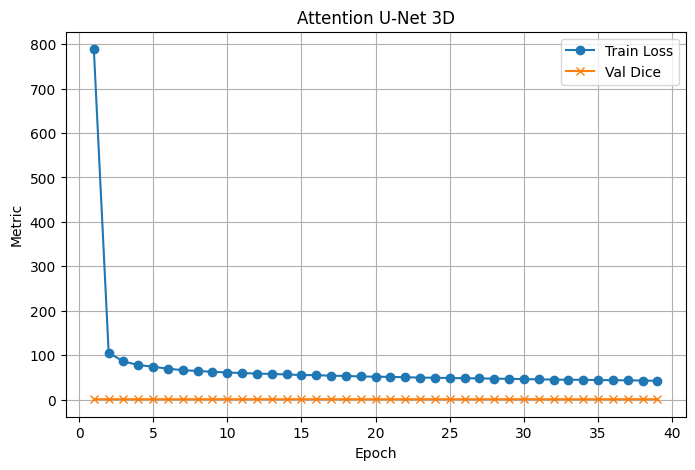

In [13]:
history_unet = train_model(UNet3D(), train_loader, val_loader, name="unet3d", epochs=50)
plot_history(history_unet, title="U-Net 3D")

history_attn = train_model(AttentionUNet3D(), train_loader, val_loader, name="att_unet3d", epochs=50)
plot_history(history_attn, title="Attention U-Net 3D")

In [10]:
for p in train_patients:
    print(os.path.basename(p))
print("Total patients:", len(train_patients))


BraTS2021_01417
BraTS2021_01632
BraTS2021_01664
BraTS2021_01305
BraTS2021_01339
BraTS2021_01155
BraTS2021_01642
BraTS2021_00548
BraTS2021_01271
BraTS2021_01030
BraTS2021_00148
BraTS2021_00049
BraTS2021_01464
BraTS2021_00732
BraTS2021_01533
BraTS2021_00280
BraTS2021_01070
BraTS2021_01245
BraTS2021_01002
BraTS2021_00512
BraTS2021_01224
BraTS2021_01366
BraTS2021_01220
BraTS2021_00273
BraTS2021_01551
BraTS2021_00753
BraTS2021_00370
BraTS2021_01063
BraTS2021_00053
BraTS2021_01038
BraTS2021_01284
BraTS2021_01188
BraTS2021_00652
BraTS2021_01649
BraTS2021_00390
BraTS2021_01225
BraTS2021_00072
BraTS2021_01405
BraTS2021_00501
BraTS2021_01213
BraTS2021_00253
BraTS2021_01421
BraTS2021_00716
BraTS2021_01277
BraTS2021_01461
BraTS2021_00100
BraTS2021_01623
BraTS2021_00414
BraTS2021_01630
BraTS2021_00549
BraTS2021_01203
BraTS2021_01128
BraTS2021_01140
BraTS2021_00723
BraTS2021_00419
BraTS2021_01040
BraTS2021_01147
BraTS2021_00612
BraTS2021_01476
BraTS2021_00655
BraTS2021_01511
BraTS2021_01435
BraTS202

In [11]:
dataset_dir = r"C:\Users\amira\Downloads\BraTS2021_Training_Data"

# Calculate the total number of patients
all_patient_ids = patient_dirs
trained_ids = train_patients
unseen_ids = list(set(all_patient_ids) - set(trained_ids))

print(f"Total patients in folder: {len(all_patient_ids)}")  # Total patients
print(f"Patients used in training: {len(trained_ids)}")     # Patients used for training
print(f"Unseen patients available for inference: {len(unseen_ids)}")  # Unseen patients


Total patients in folder: 1251
Patients used in training: 1000
Unseen patients available for inference: 251


# generate Unseen patients


In [12]:
import os

# 1. Set your dataset path
dataset_dir = r"C:\Users\amira\Downloads\BraTS2021_Training_Data"

# 2. Path to the file that contains 1000 training patient IDs (already generated)
training_ids_path = "training_patient_ids.txt"

# 3. Check if the file exists; if not, create it using train_patients
if not os.path.exists(training_ids_path):
    with open(training_ids_path, "w") as f:
        for patient in train_patients:
            f.write(os.path.basename(patient) + "\n")
    print(f"📄 Created '{training_ids_path}' with training patient IDs.")

# 4. Read training IDs
with open(training_ids_path, "r") as f:
    train_ids = set(line.strip() for line in f if line.strip())

# 4. Read all patient folders in dataset
all_patient_dirs = [d for d in os.listdir(dataset_dir) if d.startswith("BraTS2021_")]
all_patient_ids = set(all_patient_dirs)

# 5. Get unseen (non-training) patients
unseen_ids = sorted(list(all_patient_ids - train_ids))

# 6. Save unseen patients to a new file
with open("unseen_patients.txt", "w") as f:
    for pid in unseen_ids:
        f.write(pid + "\n")

# 7. Confirm
print(f"✅ Total patients in folder: {len(all_patient_ids)}")
print(f"✅ Patients used in training: {len(train_ids)}")
print(f"✅ Unseen patients available for inference: {len(unseen_ids)}")
print("📄 Saved to 'unseen_patients.txt'")


✅ Total patients in folder: 1251
✅ Patients used in training: 1000
✅ Unseen patients available for inference: 251
📄 Saved to 'unseen_patients.txt'


### 🧠 Inference with UNet3D or AttentionUNet3D + Organized Output + Metrics CSV + Overlay PNG

This notebook cell:
- Lets you choose between plain UNet3D or AttentionUNet3D
- Runs batch inference on unseen patients
- Saves `.nii.gz`, `.png`, and overlay `.png` in per-patient folders
- Computes Dice and IoU (if ground truth exists)
- Saves metrics to a CSV file


In [22]:
import os
import nibabel as nib
import numpy as np

# Example patient directory (replace with your actual patient directory)
patient_dir = r"C:\Users\amira\Downloads\BraTS2021_Training_Data\BraTS2021_00002"

# Load the FLAIR modality
flair_path = os.path.join(patient_dir, os.path.basename(patient_dir) + "_flair.nii.gz")
flair = nib.load(flair_path).get_fdata()

# Stack modalities (example with FLAIR only; add other modalities as needed)
image = np.expand_dims(flair, axis=0)  # Add channel dimension

print("Flair shape:", flair.shape)
print("Stacked image shape:", image.shape)


Flair shape: (240, 240, 155)
Stacked image shape: (1, 240, 240, 155)


In [14]:
DEVICE = torch.device("cpu")


In [28]:
import os
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import jaccard_score

# ✅ Device
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

# === UNet3D Model
class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=5):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

# === Center Crop
def center_crop_or_pad(volume, target_shape=(128, 128, 128)):
    cropped = np.zeros(target_shape, dtype=volume.dtype)
    input_shape = np.array(volume.shape)
    offset = (input_shape - target_shape) // 2

    crop_slices = tuple(slice(max(0, o), min(o + ts, s))
                        for o, ts, s in zip(offset, target_shape, input_shape))
    target_slices = tuple(slice(max(0, -o), max(0, -o) + cs.stop - cs.start)
                          for o, cs in zip(offset, crop_slices))
    cropped[target_slices] = volume[crop_slices]
    return cropped

# === Inference
def run_inference(model, patient_dir):
    pid = os.path.basename(patient_dir)
    modalities = ["flair", "t1", "t1ce", "t2"]
    volumes = []

    for mod in modalities:
        vol = nib.load(os.path.join(patient_dir, f"{pid}_{mod}.nii.gz")).get_fdata()
        vol = np.transpose(vol, (2, 0, 1))  # D, H, W
        vol = center_crop_or_pad(vol)
        volumes.append(vol)

    image = np.stack(volumes, axis=0).astype(np.float32)  # [4, 128, 128, 128]
    image_tensor = torch.tensor(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Load and prepare GT segmentation
    seg_path = os.path.join(patient_dir, f"{pid}_seg.nii.gz")
    if os.path.exists(seg_path):
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = np.transpose(seg, (2, 0, 1))  # D, H, W
        seg = center_crop_or_pad(seg)
        flat_gt = seg.flatten()
        flat_pred = prediction.flatten()
        intersection = np.sum(flat_pred[flat_gt == flat_pred])
        dice = (2. * intersection) / (np.sum(flat_gt) + np.sum(flat_pred) + 1e-8)
        iou = jaccard_score(flat_gt, flat_pred, average='macro', zero_division=0)
    else:
        seg, dice, iou = None, None, None

    return prediction, volumes[0], seg, dice, iou  # flair is volumes[0]

# === Save Outputs
def save_outputs(pid, pred, flair, gt, out_base):
    patient_out = os.path.join(out_base, pid)
    os.makedirs(patient_out, exist_ok=True)

    mid = flair.shape[0] // 2
    plt.imsave(os.path.join(patient_out, f"{pid}_pred.png"), pred[mid], cmap="gray")

    fig, ax = plt.subplots()
    ax.imshow(flair[mid], cmap="gray")
    if gt is not None:
        ax.imshow(gt[mid], alpha=0.3, cmap="Reds")
    ax.imshow(pred[mid], alpha=0.3, cmap="Blues")
    ax.axis("off")
    fig.savefig(os.path.join(patient_out, f"{pid}_overlay.png"))
    plt.close(fig)

    affine = np.eye(4)
    nib.save(nib.Nifti1Image(pred.astype(np.uint8), affine), os.path.join(patient_out, f"{pid}_pred.nii.gz"))

# === Main
data_root = r"C:\Users\amira\Downloads\BraTS2021_Training_Data"
model_path = "unet3d_best.pth"
out_dir = "safe_inference_outputs"
unseen_list = "unseen_patients.txt"
metrics_csv = os.path.join(out_dir, "metrics.csv")

model = UNet3D().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

with open(unseen_list, "r") as f:
    patients = [line.strip() for line in f if line.strip()]

os.makedirs(out_dir, exist_ok=True)
with open(metrics_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["PatientID", "Dice", "IoU"])

dice_scores, iou_scores = [], []
for pid in patients:
    print(f"🔄 Processing {pid}...")
    try:
        pred, flair, gt, dice, iou = run_inference(model, os.path.join(data_root, pid))
        save_outputs(pid, pred, flair, gt, out_dir)
        if dice is not None:
            dice_scores.append(dice)
            iou_scores.append(iou)
            with open(metrics_csv, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([pid, f"{dice:.4f}", f"{iou:.4f}"])
    except Exception as e:
        print(f"⚠️ Failed on {pid}: {e}")

print(f"\n✅ Inference done on {len(patients)} patients")
if dice_scores:
    print(f"📊 Avg Dice: {np.mean(dice_scores):.4f}")
    print(f"📊 Avg IoU : {np.mean(iou_scores):.4f}")
    print(f"📄 Saved to: {metrics_csv}")



✅ Using device: cuda
🔄 Processing BraTS2021_00002...
🔄 Processing BraTS2021_00003...
🔄 Processing BraTS2021_00009...
🔄 Processing BraTS2021_00019...
🔄 Processing BraTS2021_00020...
🔄 Processing BraTS2021_00021...
🔄 Processing BraTS2021_00032...
🔄 Processing BraTS2021_00059...
🔄 Processing BraTS2021_00063...
🔄 Processing BraTS2021_00077...
🔄 Processing BraTS2021_00084...
🔄 Processing BraTS2021_00094...
🔄 Processing BraTS2021_00095...
🔄 Processing BraTS2021_00098...
🔄 Processing BraTS2021_00099...
🔄 Processing BraTS2021_00124...
🔄 Processing BraTS2021_00131...
🔄 Processing BraTS2021_00133...
🔄 Processing BraTS2021_00134...
🔄 Processing BraTS2021_00143...
🔄 Processing BraTS2021_00151...
🔄 Processing BraTS2021_00156...
🔄 Processing BraTS2021_00160...
🔄 Processing BraTS2021_00165...
🔄 Processing BraTS2021_00171...
🔄 Processing BraTS2021_00184...
🔄 Processing BraTS2021_00185...
🔄 Processing BraTS2021_00191...
🔄 Processing BraTS2021_00194...
🔄 Processing BraTS2021_00199...
🔄 Processing BraTS2

# Attention UNET3D


In [30]:
import os
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import jaccard_score

# ✅ Device
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

# === Attention UNet3D Model
class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=5):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.att2 = AttentionBlock3D(64, 64, 32)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.att1 = AttentionBlock3D(32, 32, 16)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.att2(self.up2(b), e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.att1(self.up1(d2), e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.out_conv(d1)


# === Center Crop
def center_crop_or_pad(volume, target_shape=(128, 128, 128)):
    cropped = np.zeros(target_shape, dtype=volume.dtype)
    input_shape = np.array(volume.shape)
    offset = (input_shape - target_shape) // 2

    crop_slices = tuple(slice(max(0, o), min(o + ts, s))
                        for o, ts, s in zip(offset, target_shape, input_shape))
    target_slices = tuple(slice(max(0, -o), max(0, -o) + cs.stop - cs.start)
                          for o, cs in zip(offset, crop_slices))
    cropped[target_slices] = volume[crop_slices]
    return cropped

# === Inference
def run_inference(model, patient_dir):
    pid = os.path.basename(patient_dir)
    modalities = ["flair", "t1", "t1ce", "t2"]
    volumes = []

    for mod in modalities:
        vol = nib.load(os.path.join(patient_dir, f"{pid}_{mod}.nii.gz")).get_fdata()
        vol = np.transpose(vol, (2, 0, 1))  # D, H, W
        vol = center_crop_or_pad(vol)
        volumes.append(vol)

    image = np.stack(volumes, axis=0).astype(np.float32)  # [4, 128, 128, 128]
    image_tensor = torch.tensor(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Load and prepare GT segmentation
    seg_path = os.path.join(patient_dir, f"{pid}_seg.nii.gz")
    if os.path.exists(seg_path):
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = np.transpose(seg, (2, 0, 1))  # D, H, W
        seg = center_crop_or_pad(seg)
        flat_gt = seg.flatten()
        flat_pred = prediction.flatten()
        intersection = np.sum(flat_pred[flat_gt == flat_pred])
        dice = (2. * intersection) / (np.sum(flat_gt) + np.sum(flat_pred) + 1e-8)
        iou = jaccard_score(flat_gt, flat_pred, average='macro', zero_division=0)
    else:
        seg, dice, iou = None, None, None

    return prediction, volumes[0], seg, dice, iou  # flair is volumes[0]

# === Save Outputs
def save_outputs(pid, pred, flair, gt, out_base):
    patient_out = os.path.join(out_base, pid)
    os.makedirs(patient_out, exist_ok=True)

    mid = flair.shape[0] // 2
    plt.imsave(os.path.join(patient_out, f"{pid}_pred.png"), pred[mid], cmap="gray")

    fig, ax = plt.subplots()
    ax.imshow(flair[mid], cmap="gray")
    if gt is not None:
        ax.imshow(gt[mid], alpha=0.3, cmap="Reds")
    ax.imshow(pred[mid], alpha=0.3, cmap="Blues")
    ax.axis("off")
    fig.savefig(os.path.join(patient_out, f"{pid}_overlay.png"))
    plt.close(fig)

    affine = np.eye(4)
    nib.save(nib.Nifti1Image(pred.astype(np.uint8), affine), os.path.join(patient_out, f"{pid}_pred.nii.gz"))

# === Main
data_root = r"C:\Users\amira\Downloads\BraTS2021_Training_Data"
model_path = "att_unet3d_best.pth"
out_dir = "Attsafe_inference_outputs"
unseen_list = "unseen_patients.txt"
metrics_csv = os.path.join(out_dir, "metrics.csv")

model = AttentionUNet3D().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

with open(unseen_list, "r") as f:
    patients = [line.strip() for line in f if line.strip()]

os.makedirs(out_dir, exist_ok=True)
with open(metrics_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["PatientID", "Dice", "IoU"])

dice_scores, iou_scores = [], []
for pid in patients:
    print(f"🔄 Processing {pid}...")
    try:
        pred, flair, gt, dice, iou = run_inference(model, os.path.join(data_root, pid))
        save_outputs(pid, pred, flair, gt, out_dir)
        if dice is not None:
            dice_scores.append(dice)
            iou_scores.append(iou)
            with open(metrics_csv, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([pid, f"{dice:.4f}", f"{iou:.4f}"])
    except Exception as e:
        print(f"⚠️ Failed on {pid}: {e}")

print(f"\n✅ Inference done on {len(patients)} patients")
if dice_scores:
    print(f"📊 Avg Dice: {np.mean(dice_scores):.4f}")
    print(f"📊 Avg IoU : {np.mean(iou_scores):.4f}")
    print(f"📄 Saved to: {metrics_csv}")



✅ Using device: cuda
🔄 Processing BraTS2021_00002...
🔄 Processing BraTS2021_00003...
🔄 Processing BraTS2021_00009...
🔄 Processing BraTS2021_00019...
🔄 Processing BraTS2021_00020...
🔄 Processing BraTS2021_00021...
🔄 Processing BraTS2021_00032...
🔄 Processing BraTS2021_00059...
🔄 Processing BraTS2021_00063...
🔄 Processing BraTS2021_00077...
🔄 Processing BraTS2021_00084...
🔄 Processing BraTS2021_00094...
🔄 Processing BraTS2021_00095...
🔄 Processing BraTS2021_00098...
🔄 Processing BraTS2021_00099...
🔄 Processing BraTS2021_00124...
🔄 Processing BraTS2021_00131...
🔄 Processing BraTS2021_00133...
🔄 Processing BraTS2021_00134...
🔄 Processing BraTS2021_00143...
🔄 Processing BraTS2021_00151...
🔄 Processing BraTS2021_00156...
🔄 Processing BraTS2021_00160...
🔄 Processing BraTS2021_00165...
🔄 Processing BraTS2021_00171...
🔄 Processing BraTS2021_00184...
🔄 Processing BraTS2021_00185...
🔄 Processing BraTS2021_00191...
🔄 Processing BraTS2021_00194...
🔄 Processing BraTS2021_00199...
🔄 Processing BraTS2

# inference on the first trained model (version1)

In [34]:
import os
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import jaccard_score

# ✅ Device
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

# === UNet3D Model
class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

# === Center Crop
def center_crop_or_pad(volume, target_shape=(128, 128, 128)):
    cropped = np.zeros(target_shape, dtype=volume.dtype)
    input_shape = np.array(volume.shape)
    offset = (input_shape - target_shape) // 2
    crop_slices = tuple(slice(max(0, o), min(o + ts, s)) for o, ts, s in zip(offset, target_shape, input_shape))
    target_slices = tuple(slice(max(0, -o), max(0, -o) + cs.stop - cs.start) for o, cs in zip(offset, crop_slices))
    cropped[target_slices] = volume[crop_slices]
    return cropped


# === Inference
def run_inference(model, patient_dir):
    pid = os.path.basename(patient_dir)
    modalities = ["flair", "t1", "t1ce", "t2"]
    volumes = []

    for mod in modalities:
        vol = nib.load(os.path.join(patient_dir, f"{pid}_{mod}.nii.gz")).get_fdata()
        vol = np.transpose(vol, (2, 0, 1))  # D, H, W
        vol = center_crop_or_pad(vol)
        volumes.append(vol)

    image = np.stack(volumes, axis=0).astype(np.float32)  # [4, 128, 128, 128]
    image_tensor = torch.tensor(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()


    # Load and prepare GT segmentation
    seg_path = os.path.join(patient_dir, f"{pid}_seg.nii.gz")
    if os.path.exists(seg_path):
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = np.transpose(seg, (2, 0, 1))  # D, H, W
        seg = center_crop_or_pad(seg)
        flat_gt = seg.flatten()
        flat_pred = prediction.flatten()
        intersection = np.sum(flat_pred[flat_gt == flat_pred])
        dice = (2. * intersection) / (np.sum(flat_gt) + np.sum(flat_pred) + 1e-8)
        iou = jaccard_score(flat_gt, flat_pred, average='macro', zero_division=0)
        
    else:
        seg, dice, iou = None, None, None

    return prediction, volumes[0], seg, dice, iou  # flair is volumes[0]

# === Save Outputs
def save_outputs(pid, pred, flair, gt, out_base):
    patient_out = os.path.join(out_base, pid)
    os.makedirs(patient_out, exist_ok=True)

    mid = flair.shape[0] // 2
    plt.imsave(os.path.join(patient_out, f"{pid}_pred.png"), pred[mid], cmap="gray")

    fig, ax = plt.subplots()
    ax.imshow(flair[mid], cmap="gray")
    if gt is not None:
        ax.imshow(gt[mid], alpha=0.3, cmap="Reds")
    ax.imshow(pred[mid], alpha=0.3, cmap="Blues")
    ax.axis("off")
    fig.savefig(os.path.join(patient_out, f"{pid}_overlay.png"))
    plt.close(fig)

    affine = np.eye(4)
    nib.save(nib.Nifti1Image(pred.astype(np.uint8), affine), os.path.join(patient_out, f"{pid}_pred.nii.gz"))

# === Main
data_root = r"C:\Users\amira\Downloads\BraTS2021_Training_Data"
model_path = "unet3d_best1.pth"
out_dir = "v1safe_inference_outputs"
unseen_list = "unseen_patients.txt"
metrics_csv = os.path.join(out_dir, "metrics.csv")

model = UNet3D().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

with open(unseen_list, "r") as f:
    patients = [line.strip() for line in f if line.strip()]

os.makedirs(out_dir, exist_ok=True)
with open(metrics_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["PatientID", "Dice", "IoU"])

dice_scores, iou_scores = [], []
for pid in patients:
    print(f"🔄 Processing {pid}...")
    try:
        pred, flair, gt, dice, iou = run_inference(model, os.path.join(data_root, pid))
        save_outputs(pid, pred, flair, gt, out_dir)
        if dice is not None:
            dice_scores.append(dice)
            iou_scores.append(iou)
            with open(metrics_csv, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([pid, f"{dice:.4f}", f"{iou:.4f}"])
    except Exception as e:
        print(f"⚠️ Failed on {pid}: {e}")

print(f"\n✅ Inference done on {len(patients)} patients")
if dice_scores:
    print(f"📊 Avg Dice: {np.mean(dice_scores):.4f}")
    print(f"📊 Avg IoU : {np.mean(iou_scores):.4f}")
    print(f"📄 Saved to: {metrics_csv}")



✅ Using device: cuda
🔄 Processing BraTS2021_00002...
🔄 Processing BraTS2021_00003...
🔄 Processing BraTS2021_00009...
🔄 Processing BraTS2021_00019...
🔄 Processing BraTS2021_00020...
🔄 Processing BraTS2021_00021...
🔄 Processing BraTS2021_00032...
🔄 Processing BraTS2021_00059...
🔄 Processing BraTS2021_00063...
🔄 Processing BraTS2021_00077...
🔄 Processing BraTS2021_00084...
🔄 Processing BraTS2021_00094...
🔄 Processing BraTS2021_00095...
🔄 Processing BraTS2021_00098...
🔄 Processing BraTS2021_00099...
🔄 Processing BraTS2021_00124...
🔄 Processing BraTS2021_00131...
🔄 Processing BraTS2021_00133...
🔄 Processing BraTS2021_00134...
🔄 Processing BraTS2021_00143...
🔄 Processing BraTS2021_00151...
🔄 Processing BraTS2021_00156...
🔄 Processing BraTS2021_00160...
🔄 Processing BraTS2021_00165...
🔄 Processing BraTS2021_00171...
🔄 Processing BraTS2021_00184...
🔄 Processing BraTS2021_00185...
🔄 Processing BraTS2021_00191...
🔄 Processing BraTS2021_00194...
🔄 Processing BraTS2021_00199...
🔄 Processing BraTS2

#  Full Inference Cell (UNet3D + AttentionUNet3D Ensemble) on one trained patient

In [45]:
for modality in ["flair", "t1", "t1ce", "t2"]:
    fpath = os.path.join(patient_dir, f"{pid}_{modality}.nii.gz")
    print(modality, "exists:", os.path.exists(fpath))


flair exists: True
t1 exists: True
t1ce exists: True
t2 exists: True


In [44]:
import os
import nibabel as nib
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# === Load both models ===
unet = UNet3D(in_channels=4, out_channels=3).to(DEVICE)
unet.load_state_dict(torch.load("unet3d_best1.pth", map_location=DEVICE))
unet.eval()

att_unet = AttentionUNet3D(in_channels=4, out_channels=3).to(DEVICE)
att_unet.load_state_dict(torch.load("att_unet3d_best1.pth", map_location=DEVICE))
att_unet.eval()

# === Patient directory
patient_dir = r"C:\Users\amira\Downloads\BraTS2021_Training_Data\BraTS2021_00022"
pid = os.path.basename(patient_dir)
out_path = "ensemble_one_patient_output"
os.makedirs(out_path, exist_ok=True)

# === Load and preprocess modalities
modalities = ["flair", "t1", "t1ce", "t2"]
images = []
for modality in modalities:
    vol = nib.load(os.path.join(patient_dir, f"{pid}_{modality}.nii.gz")).get_fdata()
    vol = np.transpose(vol, (2, 0, 1))  # (H, W, D) -> (D, H, W)
    vol = center_crop_or_pad(vol, (128, 128, 128))
    images.append(vol)

image = np.stack(images, axis=0).astype(np.float32)
image = (image - np.mean(image)) / (np.std(image) + 1e-8)
image_tensor = torch.tensor(image).unsqueeze(0).to(DEVICE)

# === Inference
with torch.no_grad():
    out1 = unet(image_tensor)
    out2 = att_unet(image_tensor)

    prob1 = torch.softmax(out1, dim=1)
    prob2 = torch.softmax(out2, dim=1)

    avg_prob = (prob1 + prob2) / 2
    ensemble_pred = torch.argmax(avg_prob, dim=1).squeeze(0).cpu().numpy()

def compute_dice_iou(pred, gt, num_classes=3):
    dice_scores = []
    iou_scores = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        gt_cls = (gt == cls)
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()
        pred_sum = pred_cls.sum()
        gt_sum = gt_cls.sum()
        dice = (2. * intersection) / (pred_sum + gt_sum + 1e-8) if (pred_sum + gt_sum) > 0 else np.nan
        iou = intersection / (union + 1e-8) if union > 0 else np.nan
        dice_scores.append(dice)
        iou_scores.append(iou)
    # Mean over classes, ignoring NaN
    dice_mean = np.nanmean(dice_scores)
    iou_mean = np.nanmean(iou_scores)
    return dice_mean, iou_mean

# === Load and preprocess ground truth
seg_path = os.path.join(patient_dir, f"{pid}_seg.nii.gz")
if os.path.exists(seg_path):
    seg = nib.load(seg_path).get_fdata()
    seg = np.transpose(seg, (2, 0, 1))
    seg = center_crop_or_pad(seg, (128, 128, 128))
    seg = np.where(seg == 4, 3, seg).astype(np.uint8)
    dice, iou = compute_dice_iou(ensemble_pred, seg)
    print(f"✅ Ensemble Dice: {dice:.4f}, IoU: {iou:.4f}")
else:
    seg = None
    print("⚠️ No ground truth segmentation found.")

# === Save overlay
mid = ensemble_pred.shape[0] // 2
plt.imsave(os.path.join(out_path, f"{pid}_ensemble_pred.png"), ensemble_pred[mid], cmap="Blues")

fig, ax = plt.subplots()
ax.imshow(image[0, mid], cmap="gray")
if seg is not None:
    ax.imshow(seg[mid], alpha=0.3, cmap="Reds")
ax.imshow(ensemble_pred[mid], alpha=0.3, cmap="Blues")
ax.axis("off")
fig.savefig(os.path.join(out_path, f"{pid}_ensemble_overlay.png"))
plt.close(fig)

# === Save NIfTI
nib.save(nib.Nifti1Image(ensemble_pred.astype(np.uint8), affine=np.eye(4)),
         os.path.join(out_path, f"{pid}_ensemble_pred.nii.gz"))


✅ Ensemble Dice: 0.3721, IoU: 0.3416


# another patient , to compare


In [57]:
import os
import nibabel as nib
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# === Load both models ===
unet = UNet3D(in_channels=4, out_channels=3).to(DEVICE)
unet.load_state_dict(torch.load("unet3d_best1.pth", map_location=DEVICE))
unet.eval()

att_unet = AttentionUNet3D(in_channels=4, out_channels=3).to(DEVICE)
att_unet.load_state_dict(torch.load("att_unet3d_best1.pth", map_location=DEVICE))
att_unet.eval()

# === Patient directory
patient_dir = r"C:\Users\amira\Downloads\BraTS2021_Training_Data\BraTS2021_00000"
pid = os.path.basename(patient_dir)
out_path = "ensemble_one_patient100_output"
os.makedirs(out_path, exist_ok=True)

# === Load and preprocess modalities
modalities = ["flair", "t1", "t1ce", "t2"]
images = []
for modality in modalities:
    vol = nib.load(os.path.join(patient_dir, f"{pid}_{modality}.nii.gz")).get_fdata()
    vol = np.transpose(vol, (2, 0, 1))  # (H, W, D) -> (D, H, W)
    vol = center_crop_or_pad(vol, (128, 128, 128))
    images.append(vol)

image = np.stack(images, axis=0).astype(np.float32)
image = (image - np.mean(image)) / (np.std(image) + 1e-8)
image_tensor = torch.tensor(image).unsqueeze(0).to(DEVICE)

# === Inference
with torch.no_grad():
    out1 = unet(image_tensor)
    out2 = att_unet(image_tensor)

    prob1 = torch.softmax(out1, dim=1)
    prob2 = torch.softmax(out2, dim=1)

    avg_prob = (prob1 + prob2) / 2
    ensemble_pred = torch.argmax(avg_prob, dim=1).squeeze(0).cpu().numpy()

def compute_dice_iou(pred, gt, num_classes=3):
    dice_scores = []
    iou_scores = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        gt_cls = (gt == cls)
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()
        pred_sum = pred_cls.sum()
        gt_sum = gt_cls.sum()
        dice = (2. * intersection) / (pred_sum + gt_sum + 1e-8) if (pred_sum + gt_sum) > 0 else np.nan
        iou = intersection / (union + 1e-8) if union > 0 else np.nan
        dice_scores.append(dice)
        iou_scores.append(iou)
    # Mean over classes, ignoring NaN
    dice_mean = np.nanmean(dice_scores)
    iou_mean = np.nanmean(iou_scores)
    return dice_mean, iou_mean

# === Load and preprocess ground truth
seg_path = os.path.join(patient_dir, f"{pid}_seg.nii.gz")
if os.path.exists(seg_path):
    seg = nib.load(seg_path).get_fdata()
    seg = np.transpose(seg, (2, 0, 1))
    seg = center_crop_or_pad(seg, (128, 128, 128))
    seg = np.where(seg == 4, 3, seg).astype(np.uint8)
    dice, iou = compute_dice_iou(ensemble_pred, seg)
    print(f"✅ Ensemble Dice: {dice:.4f}, IoU: {iou:.4f}")
else:
    seg = None
    print("⚠️ No ground truth segmentation found.")

# === Save overlay
mid = ensemble_pred.shape[0] // 2
plt.imsave(os.path.join(out_path, f"{pid}_ensemble_pred.png"), ensemble_pred[mid], cmap="Blues")

fig, ax = plt.subplots()
ax.imshow(image[0, mid], cmap="gray")
if seg is not None:
    ax.imshow(seg[mid], alpha=0.3, cmap="Reds")
ax.imshow(ensemble_pred[mid], alpha=0.3, cmap="Blues")
ax.axis("off")
fig.savefig(os.path.join(out_path, f"{pid}_ensemble_overlay.png"))
plt.close(fig)

# === Save NIfTI
nib.save(nib.Nifti1Image(ensemble_pred.astype(np.uint8), affine=np.eye(4)),
         os.path.join(out_path, f"{pid}_ensemble_pred.nii.gz"))




✅ Ensemble Dice: 0.3289, IoU: 0.3246


In [53]:
for cls, (d, i) in enumerate(zip(dice_scores, iou_scores)):
    print(f"Class {cls} → Dice: {d:.4f}, IoU: {i:.4f}")



Class 0 → Dice: 0.2779, IoU: 0.2022
Class 1 → Dice: 0.0828, IoU: 0.1131
Class 2 → Dice: 0.0371, IoU: 0.2199
Class 3 → Dice: 0.1758, IoU: 0.1211
Class 4 → Dice: 0.0333, IoU: 0.1613
Class 5 → Dice: 0.1398, IoU: 0.1468
Class 6 → Dice: 0.1853, IoU: 0.1972
Class 7 → Dice: 0.1378, IoU: 0.1388
Class 8 → Dice: 0.0204, IoU: 0.0949
Class 9 → Dice: 0.1724, IoU: 0.1321
Class 10 → Dice: 0.0720, IoU: 0.1461
Class 11 → Dice: 0.0914, IoU: 0.1250
Class 12 → Dice: 0.1837, IoU: 0.1796
Class 13 → Dice: 0.0227, IoU: 0.1347
Class 14 → Dice: 0.1725, IoU: 0.2094
Class 15 → Dice: 0.0790, IoU: 0.1073
Class 16 → Dice: 0.1036, IoU: 0.1141
Class 17 → Dice: 0.0786, IoU: 0.1252
Class 18 → Dice: 0.0645, IoU: 0.1035
Class 19 → Dice: 0.1157, IoU: 0.1347
Class 20 → Dice: 0.1242, IoU: 0.1322
Class 21 → Dice: 0.1054, IoU: 0.1191
Class 22 → Dice: 0.2310, IoU: 0.1858
Class 23 → Dice: 0.1111, IoU: 0.1646
Class 24 → Dice: 0.0838, IoU: 0.1760
Class 25 → Dice: 0.1294, IoU: 0.1630
Class 26 → Dice: 0.0900, IoU: 0.1756
Class 27 → 

# 💾 Save Predicted Mask as .nii.gz

This is useful when you want to visualize or process the segmentation result in tools like 3D Slicer, ITK-SNAP, or use for clinical post-processing.

In [58]:
def save_prediction_as_nifti(prediction, reference_nifti_path, output_path):
    """
    Saves a 3D numpy array (prediction) as a .nii.gz file using the affine and header from a reference image.
    """
    reference_nifti = nib.load(reference_nifti_path)
    pred_nifti = nib.Nifti1Image(prediction.astype(np.uint8), affine=reference_nifti.affine, header=reference_nifti.header)
    nib.save(pred_nifti, output_path)
    print(f"✅ Saved predicted mask as: {output_path}")


# Assuming you already have `pred` from the previous inference
# Use an existing patient directory, e.g., patient_dir or another variable
ref_img_path = os.path.join(patient_dir, os.path.basename(patient_dir) + "_flair.nii.gz")
output_path = "BraTS2021_00000_predicted_mask.nii.gz"

save_prediction_as_nifti(pred, ref_img_path, output_path)


✅ Saved predicted mask as: BraTS2021_00000_predicted_mask.nii.gz


# Class Distribution Analysis
This helps you analyze label imbalance across the segmentation masks, which is common in medical datasets like BraTS (e.g., large background, small tumor).

Class 0: 180146012 voxels (98.13%)
Class 1: 1079615 voxels (0.59%)
Class 2: 2355999 voxels (1.28%)
Class 3: 0 voxels (0.00%)


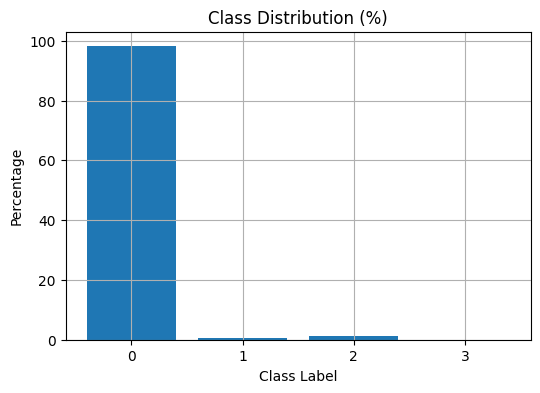

Class 0: 181387891 voxels (98.82%)
Class 1: 442879 voxels (0.24%)
Class 2: 1728326 voxels (0.94%)
Class 3: 0 voxels (0.00%)


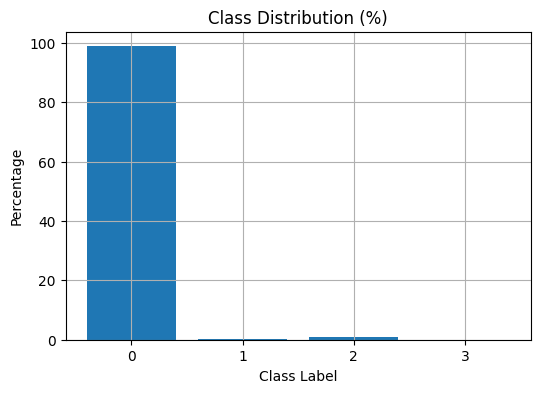

In [62]:
# 📊 Function to Analyze Label Frequencies:
import numpy as np
import matplotlib.pyplot as plt

def analyze_class_distribution(dataset, num_classes=4):
    class_counts = np.zeros(num_classes)

    for i in range(min(100, len(dataset))):  # analyze first 100 samples to save RAM
        _, mask = dataset[i]
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            if u < num_classes:
                class_counts[int(u)] += c

    total = class_counts.sum()
    percentages = 100 * class_counts / total

    for cls in range(num_classes):
        print(f"Class {cls}: {int(class_counts[cls])} voxels ({percentages[cls]:.2f}%)")

    plt.figure(figsize=(6, 4))
    plt.bar(range(num_classes), percentages)
    plt.xticks(range(num_classes))
    plt.title("Class Distribution (%)")
    plt.xlabel("Class Label")
    plt.ylabel("Percentage")
    plt.grid(True)
    plt.show()
# 📊 Analyze Class Distribution in Training Dataset
analyze_class_distribution(train_dataset, num_classes=4)
# 📊 Analyze Class Distribution in Validation Dataset
analyze_class_distribution(val_dataset, num_classes=4)
# (No test_dataset defined, so skip test set analysis)

# 📄 Save unseen patient IDs to a text file
unseen_patients = ["BraTS2021_00001", "BraTS2021_00002", "BraTS2021_00003"]  # Example unseen patients
with open("unseen_patients.txt", "w") as f:
    for pid in unseen_patients:
        f.write(f"{pid}\n")


# Model Summary with torchinfo
This helps visualize the architecture, layer-wise output shapes, and parameter counts for each model. Very useful for documentation and debugging.

In [ ]:
from torchinfo import summary

def show_model_summary(model_class, input_shape=(1, 4, 128, 128, 64), name="Model"):
    print(f"\n📊 Summary for {name}")
    model = model_class().to(DEVICE)
    summary(model, input_size=input_shape, depth=3, col_names=["input_size", "output_size", "num_params"])
    
show_model_summary(UNet3D, name="U-Net 3D")
show_model_summary(AttentionUNet3D, name="Attention U-Net 3D")




📊 Summary for U-Net 3D

📊 Summary for Attention U-Net 3D


In [66]:
import seaborn as sns

# === Slice-level Dice calculation for a specific class (e.g., tumor)
def slice_dice(gt, pred, cls):
    scores = []
    for i in range(gt.shape[0]):
        gt_slice = (gt[i] == cls)
        pred_slice = (pred[i] == cls)
        intersection = np.logical_and(gt_slice, pred_slice).sum()
        denom = gt_slice.sum() + pred_slice.sum()
        dice = (2. * intersection / (denom + 1e-8)) if denom > 0 else np.nan
        scores.append(dice)
    return np.array(scores)

# === Compute Dice per slice for each class (1: tumor core, 2: enhancing tumor, etc.)
cls = 1  # or test cls = 2, 3 if desired
slice_dice_scores = slice_dice(seg, ensemble_pred, cls)

# === Get indices of top/bottom 5
valid_indices = ~np.isnan(slice_dice_scores)
sorted_indices = np.argsort(slice_dice_scores[valid_indices])
worst5 = sorted_indices[:5]
best5 = sorted_indices[-5:][::-1]

# === Helper to plot
def save_slice(idx, kind):
    fig, ax = plt.subplots()
    ax.imshow(image[0, idx], cmap='gray')
    ax.imshow(seg[idx] == cls, alpha=0.3, cmap='Reds')
    ax.imshow(ensemble_pred[idx] == cls, alpha=0.3, cmap='Blues')
    ax.set_title(f"{kind} Slice {idx} — Dice: {slice_dice_scores[idx]:.4f}")
    ax.axis('off')
    fig.savefig(os.path.join(out_path, f"{pid}_{kind.lower()}_slice_{idx}_dice_{slice_dice_scores[idx]:.4f}.png"))
    plt.close(fig)

# === Save best and worst slices
for idx in best5:
    save_slice(idx, "BEST")

for idx in worst5:
    save_slice(idx, "WORST")

print("✅ Top-5 best and worst slices saved for class", cls)
def center_crop_or_pad(volume, target_shape=(128, 128, 128)):
    """
    Center crops or pads a 3D volume to the target shape.
    """
    cropped = np.zeros(target_shape, dtype=volume.dtype)
    input_shape = np.array(volume.shape)
    offset = (input_shape - target_shape) // 2
    crop_slices = tuple(slice(max(0, o), min(o + ts, s)) for o, ts, s in zip(offset, target_shape, input_shape))
    target_slices = tuple(slice(max(0, -o), max(0, -o) + cs.stop - cs.start)
                          for o, cs in zip(offset, crop_slices))
    cropped[target_slices] = volume[crop_slices]
    return cropped
# === Center crop or pad a 3D volume to the target shape
def center_crop_or_pad(volume, target_shape=(128, 128, 128)):
    """
    Center crops or pads a 3D volume to the target shape.
    """
    cropped = np.zeros(target_shape, dtype=volume.dtype)
    input_shape = np.array(volume.shape)
    offset = (input_shape - target_shape) // 2

    crop_slices = tuple(slice(max(0, o), min(o + ts, s))
                        for o, ts, s in zip(offset, target_shape, input_shape))
    target_slices = tuple(slice(max(0, -o), max(0, -o) + cs.stop - cs.start)
                          for o, cs in zip(offset, crop_slices))
    cropped[target_slices] = volume[crop_slices]
    return cropped

✅ Top-5 best and worst slices saved for class 1


📉 Worst slices: [(36, 0.0), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.0)]
📈 Best slices: [(78, 0.0), (79, 0.0), (80, 0.0), (81, 0.0), (82, 0.0)]


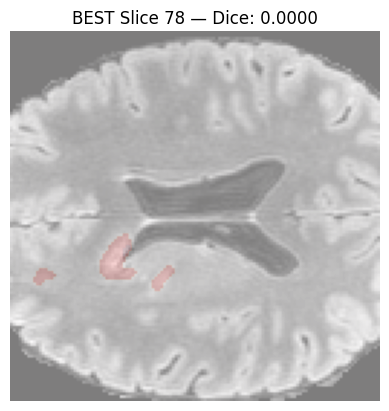

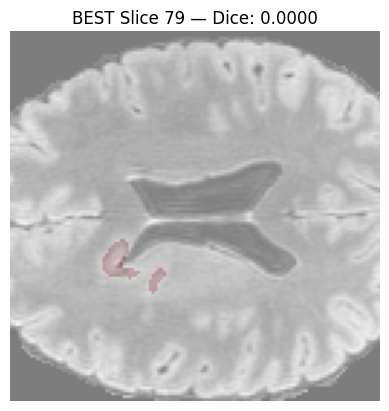

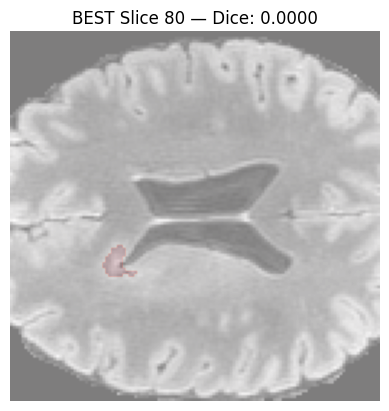

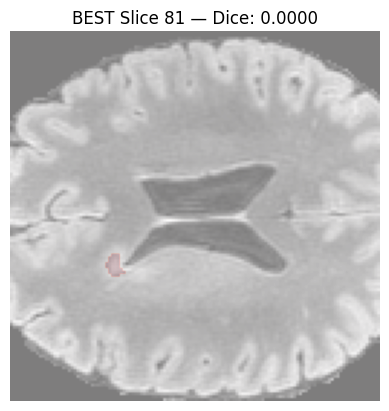

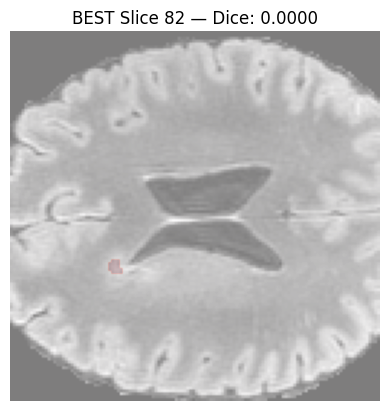

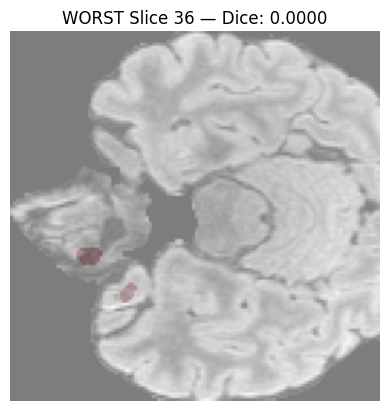

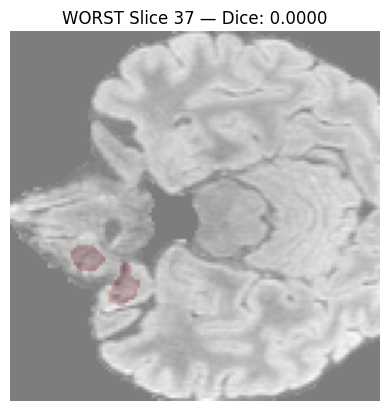

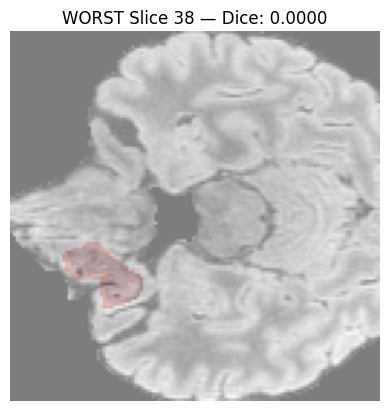

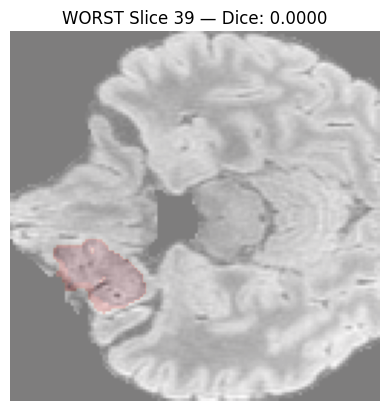

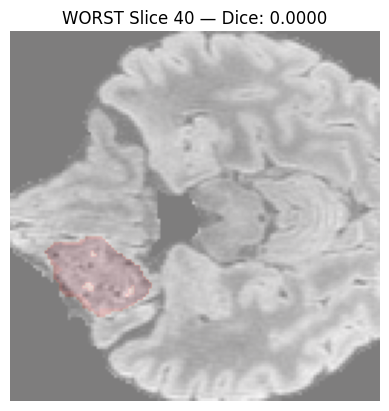

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def per_slice_dice(gt, pred):
    """Compute Dice score per slice, ignoring background-only slices."""
    assert gt.shape == pred.shape, "Shapes must match"
    dice_scores = []
    for i in range(gt.shape[0]):
        g, p = gt[i], pred[i]
        if np.sum(g) == 0 and np.sum(p) == 0:
            continue  # Ignore slices with only background
        intersection = np.sum((g == p) & (g > 0))
        dice = (2. * intersection) / (np.sum(g > 0) + np.sum(p > 0) + 1e-8)
        dice_scores.append((i, dice))
    return dice_scores

def plot_slices(slices, image, pred, gt, title_prefix):
    for idx, score in slices:
        fig, ax = plt.subplots()
        ax.imshow(image[0, idx], cmap="gray")
        if gt is not None:
            ax.imshow(gt[idx], alpha=0.3, cmap="Reds")
        ax.imshow(pred[idx], alpha=0.3, cmap="Blues")
        ax.axis("off")
        ax.set_title(f"{title_prefix} Slice {idx} — Dice: {score:.4f}")
        plt.show()

# === Compute and sort slice-wise Dice scores
slice_dice_scores = per_slice_dice(seg, ensemble_pred)
slice_dice_scores.sort(key=lambda x: x[1])  # sort ascending by Dice

# === Select bottom 5 and top 5
worst_5 = slice_dice_scores[:5]
best_5 = slice_dice_scores[-5:]

print("📉 Worst slices:", worst_5)
print("📈 Best slices:", best_5)

# === Plot
plot_slices(best_5, image, ensemble_pred, seg, "BEST")
plot_slices(worst_5, image, ensemble_pred, seg, "WORST")


## ✅ Summary & Deployment Tips
- Best Dice model saved as `.pth`
- Deployment-ready formats: `.pt` (TorchScript), `.onnx`
- Use ONNX for ONNX Runtime, TensorRT, or OpenVINO.
- Ideal for mobile, embedded, or web deployment.

**Next step:** Try converting the ONNX model into TensorRT or integrating in a simple Flask demo.